In [ ]:
# Import libraries
import os
import zipfile
import cv2
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras import backend as K

import shutil

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import img_to_array, load_img

%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import random

import pickle
from tqdm import tqdm

import cv2

from shutil import copyfile

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
PATH = os.getcwd()
# Define data path
source_path = '/content/gdrive/MyDrive/Dataset/PetImages'
source_path_train_validation= '/content/gdrive/MyDrive/Dataset/catvsdogtrainvali'
source_dir_list = os.listdir(source_path)
source_dir_list

folders = ['Validation', 'Train']

# Klasörleri oluşturma işlemi
for folder in folders:
    folder_path = os.path.join(source_path_train_validation, folder)
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print(f"{folder} klasörü oluşturuldu.")
    else:
        print(f"{folder} klasörü zaten mevcut.")

# Oluşturulan klasörlerin içeriğini kontrol etme
source_dir_list = os.listdir(source_path_train_validation)
print("\nContents of source directory:")
print(source_dir_list)

CATEGORIES=["Cat","Dog"]

# Yeni kombinasyon kategorileri ekleyin

validation_path = os.path.join(source_path_train_validation, 'Validation')
train_path = os.path.join(source_path_train_validation, 'Train')

SPLIT_SIZE=0.80


Validation klasörü oluşturuldu.
Train klasörü oluşturuldu.

Contents of source directory:
['Validation', 'Train']


In [ ]:
source_path_cats = os.path.join(source_path, 'Cat')
source_path_dogs = os.path.join(source_path, 'Dog')

print(f"There are {len(os.listdir(source_path_cats))} images of cats.")
print(f"There are {len(os.listdir(source_path_dogs))} images of dogs.")


There are 9769 images of cats.
There are 7663 images of dogs.


In [ ]:
nrows = 4
ncols = 4
pic_index = 0

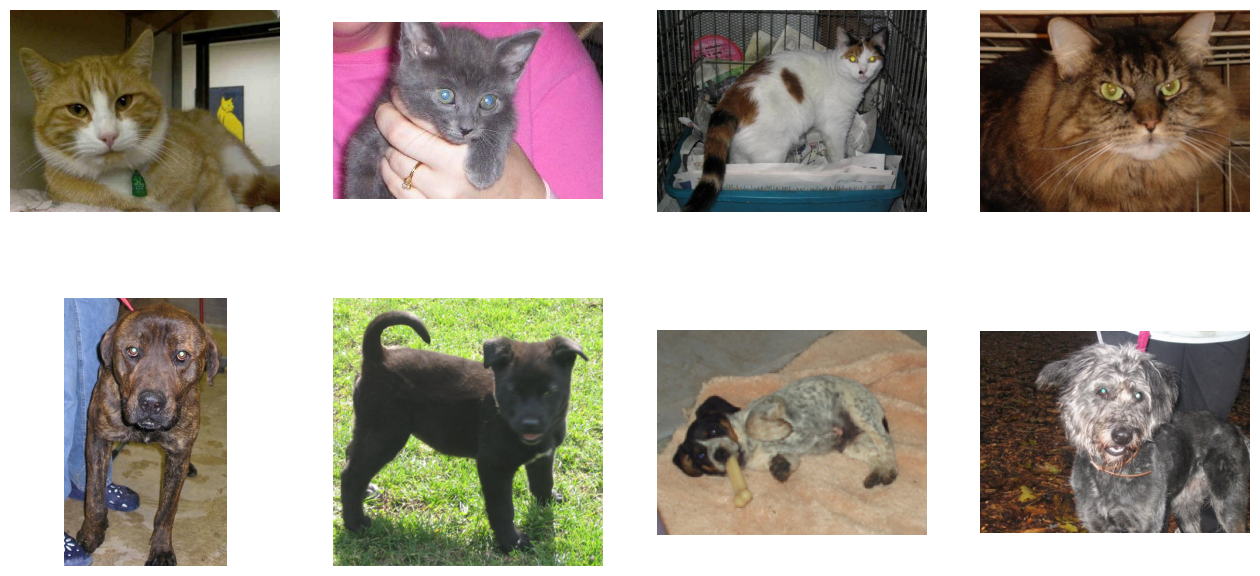

(-0.5, 199.5, 161.5, -0.5)

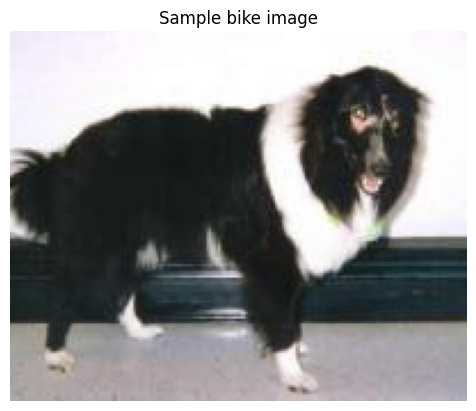

In [ ]:
pig = plt.gcf()
pig.set_size_inches(ncols * 4, nrows * 4)

# Başlangıç indeksini belirleme
pic_index_start = random.randint(0, len(os.listdir(source_path_cats)) - 4)
pic_index_end = pic_index_start + 4

next_cat_pix = [os.path.join(source_path_cats, fname)
                for fname in os.listdir(source_path_cats)[pic_index_start:pic_index_end]
                ]
next_dog_pix = [os.path.join(source_path_dogs, fname)
                for fname in os.listdir(source_path_dogs)[pic_index_start:pic_index_end]
                ]

# Tüm resimleri birleştir
all_pix = next_cat_pix + next_dog_pix

for i, img_path in enumerate(all_pix):
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off')

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()

plt.imshow(load_img(f"{os.path.join(source_path_dogs, os.listdir(source_path_dogs)[5])}"))
plt.title("Sample bike image")
plt.axis("off")

In [ ]:
def split_data(SOURCE, TRAINING, VALIDATION, SPLIT_SIZE):
    files = []
    for filename in os.listdir(SOURCE):
        file = os.path.join(SOURCE, filename)
        if os.path.getsize(file) > 0:
            files.append(filename)
        else:
            print(f'{filename} is zero length, so ignoring.')

    training_length = int(len(files) * SPLIT_SIZE)
    validation_length = len(files) - training_length
    shuffled_set = random.sample(files, len(files))
    training_set = shuffled_set[:training_length]
    validation_set = shuffled_set[training_length:]

    for filename in training_set:
        src_file = os.path.join(SOURCE, filename)
        dest_file = os.path.join(TRAINING, filename)
        copyfile(src_file, dest_file)

    for filename in validation_set:
        src_file = os.path.join(SOURCE, filename)
        dest_file = os.path.join(VALIDATION, filename)
        copyfile(src_file, dest_file)

for category in CATEGORIES:
    val_category_path = os.path.join(validation_path, category)
    train_category_path = os.path.join(train_path, category)
    if not os.path.exists(val_category_path):
        os.makedirs(val_category_path)
    if not os.path.exists(train_category_path):
        os.makedirs(train_category_path)


from shutil import copyfile

# Kategorilerin alt klasörlerine veri kopyalama işlemi
for category in CATEGORIES:
    category_path = os.path.join(source_path, category)
    val_category_path = os.path.join(validation_path, category)
    train_category_path = os.path.join(train_path, category)

    # Veri setini belirtilen oranda bölmek için split_data fonksiyonunu çağırma
    split_data(category_path, train_category_path, val_category_path, SPLIT_SIZE)

# Split işleminden sonra eğitim ve doğrulama setlerinin içeriğini kontrol etme
print("\nContents of training directory:")
print(os.listdir(train_path))
print("\nContents of validation directory:")

print(os.listdir(validation_path))

666.jpg is zero length, so ignoring.
11702.jpg is zero length, so ignoring.

Contents of training directory:
['Cat', 'Dog']

Contents of validation directory:
['Cat', 'Dog']


In [ ]:
# Her bir kategori için eğitim ve doğrulama setlerindeki dosya sayısını yazdırma
for category in CATEGORIES:
    train_category_path = os.path.join(train_path, category)
    validation_category_path = os.path.join(validation_path, category)

    num_train_files = len(os.listdir(train_category_path))
    num_validation_files = len(os.listdir(validation_category_path))

    print(f"There are {num_train_files} images of {category} for training")
    print(f"There are {num_validation_files} images of {category} for validation")
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  #train_datagen = ImageDataGenerator( rescale = 1.0/255. )

  train_datagen = ImageDataGenerator(rescale=1./255,
                                      rotation_range=50,
                                      horizontal_flip=True,
                                      height_shift_range=0.2,
                                      zoom_range=0.2,
                                      width_shift_range=0.2,
                                      shear_range=0.2,
                                      fill_mode='nearest')


  train_generator = train_datagen.flow_from_directory(TRAINING_DIR,
                                                        batch_size=16,
                                                        class_mode='binary',
                                                        target_size=(150, 150))

  validation_datagen  = ImageDataGenerator( rescale = 1.0/255. )

  validation_generator = validation_datagen.flow_from_directory(VALIDATION_DIR,
                                                                  batch_size=16,
                                                                  class_mode='binary',
                                                                  target_size=(150, 150))

  return train_generator, validation_generator

There are 7814 images of Cat for training
There are 1954 images of Cat for validation
There are 6130 images of Dog for training
There are 1533 images of Dog for validation


In [ ]:
train_generator, validation_generator = train_val_generators(train_path, validation_path)

Found 13943 images belonging to 2 classes.
Found 3487 images belonging to 2 classes.


In [43]:
from tensorflow.keras.regularizers import l2
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam

def create_model():
  model = tf.keras.models.Sequential([
      tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
      tf.keras.layers.MaxPooling2D(2, 2),


      tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),

      tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
      tf.keras.layers.MaxPooling2D(2,2),

      tf.keras.layers.Flatten(),
      tf.keras.layers.Dense(512, activation='relu'),
      tf.keras.layers.Dense(1, activation='sigmoid')  # Çıkış katmanı, sınıf sayısına göre ayarlanır
  ])

  # Modeli derleme

  model.compile(optimizer=Adam(learning_rate=0.0001),  # Öğrenme oranını burada ayarlayın
              loss='binary_crossentropy',
              metrics=['accuracy'])

  return model

In [44]:
model=create_model()

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 148, 148, 16)      448       
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 74, 74, 16)        0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 72, 72, 32)        4640      
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 36, 36, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_23 (Conv2D)          (None, 34, 34, 64)        18496     
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 17, 17, 64)       

In [45]:
model = create_model()
history = model.fit(
    train_generator,
    epochs=15,  # İterasyon sayısı, kendi projenize göre ayarlayın
    verbose=1,
    validation_data=validation_generator,
)

Epoch 1/15
698/698 [==============================] - 592s 843ms/step - loss: 0.6410 - accuracy: 0.6327 - val_loss: 0.5895 - val_accuracy: 0.6903
Epoch 2/15
698/698 [==============================] - 578s 827ms/step - loss: 0.5970 - accuracy: 0.6815 - val_loss: 0.5438 - val_accuracy: 0.7405
Epoch 3/15
698/698 [==============================] - 578s 827ms/step - loss: 0.5720 - accuracy: 0.7039 - val_loss: 0.5331 - val_accuracy: 0.7304
Epoch 4/15
698/698 [==============================] - 571s 817ms/step - loss: 0.5589 - accuracy: 0.7117 - val_loss: 0.5016 - val_accuracy: 0.7571
Epoch 5/15
698/698 [==============================] - 573s 820ms/step - loss: 0.5442 - accuracy: 0.7209 - val_loss: 0.4991 - val_accuracy: 0.7548
Epoch 6/15
698/698 [==============================] - 573s 821ms/step - loss: 0.5331 - accuracy: 0.7352 - val_loss: 0.4792 - val_accuracy: 0.7706
Epoch 7/15
698/698 [==============================] - 575s 824ms/step - loss: 0.5220 - accuracy: 0.7373 - val_loss: 0.4866 -

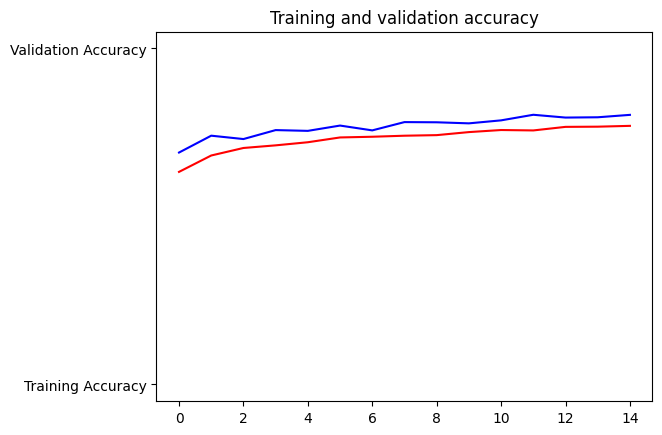

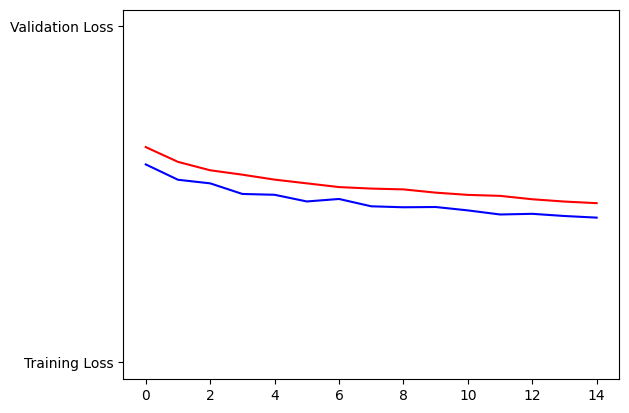

In [47]:

acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc))

plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.show()
print("")

plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.show()

In [ ]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np


# Kullanıcıdan görüntü dosyasını seçmesini isteyin
uploaded = files.upload()

# Yüklenen dosyanın adını alın
file_name = next(iter(uploaded))

# Seçilen dosyayı kullanarak görüntüyü yükleyin (150x150 piksel boyutunda)
img = image.load_img(file_name, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0  # Görüntüyü normalleştirin

# Geri kalan işlemi buraya ekleyin: Tahmin işlemi vb.

Saving 7919.jpg to 7919.jpg


1/1 [==============================] - 0s 34ms/step


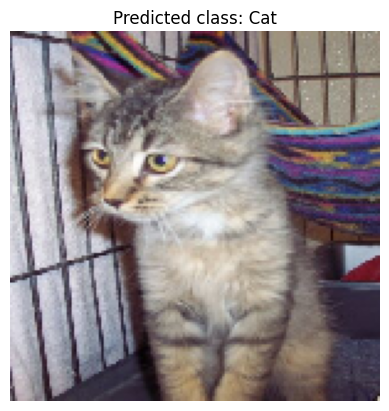

In [ ]:
# Tahmin işlemi
predictions = model.predict(img_array)

# Tahmin edilen sınıfın indeksini alın
predicted_class_index = np.argmax(predictions)

# Tahmin edilen sınıfın adını alın
predicted_class = CATEGORIES[predicted_class_index]

# Görüntüyü ve tahmin edilen sınıfı gösterin
plt.imshow(img)
plt.title(f'Predicted class: {predicted_class}')
plt.axis('off')
plt.show()


In [ ]:
train_cat=os.path.join(train_path,'Cat')
train_dog=os.path.join(train_path,'Dog')

train_cat_fnames = os.listdir( train_cat )
train_dog_fnames = os.listdir( train_dog )

print(train_cat_fnames[:10])
print(train_dog_fnames[:10])

['5434.jpg', '3854.jpg', '1947.jpg', '2956.jpg', '4850.jpg', '11110.jpg', '2486.jpg', '1880.jpg', '10999.jpg', '3732.jpg']
['1932.jpg', '3440.jpg', '1343.jpg', '3749.jpg', '2697.jpg', '2692.jpg', '1123.jpg', '813.jpg', '138.jpg', '2347.jpg']


1/1 [==============================] - 0s 111ms/step


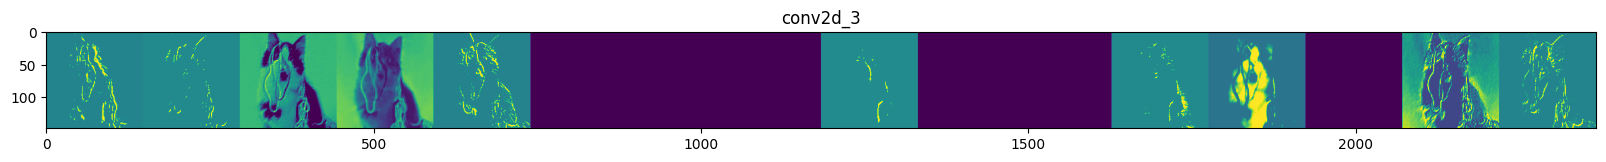

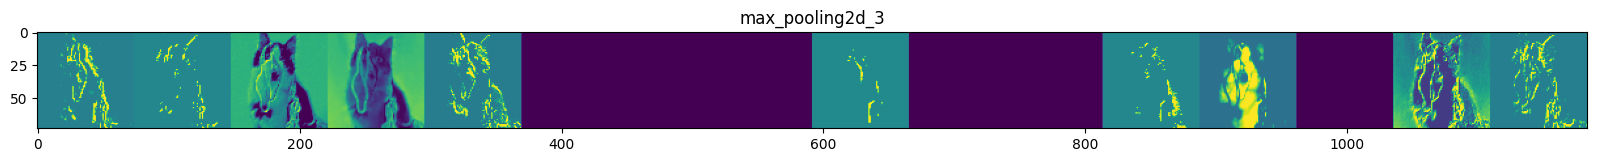

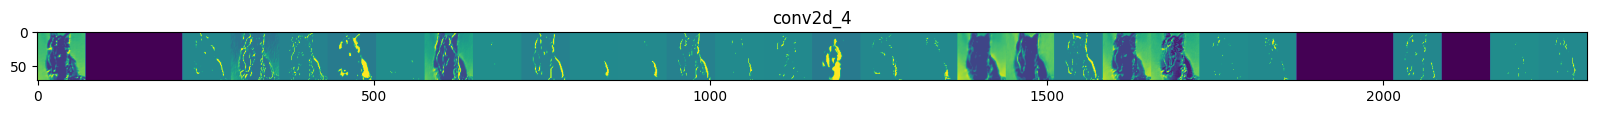

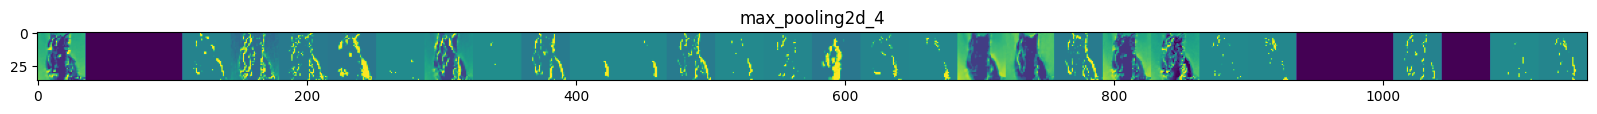

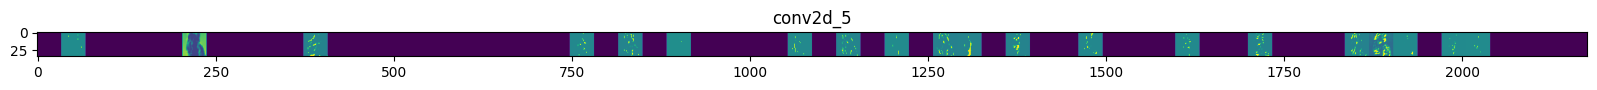

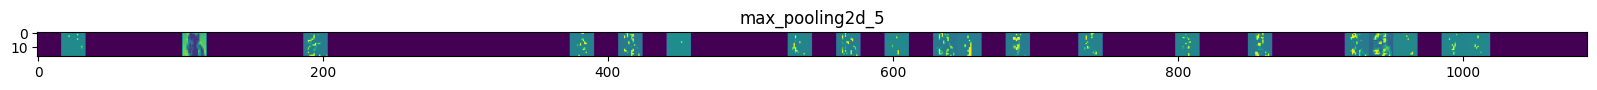

In [ ]:

successive_outputs = [layer.output for layer in model.layers]
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)


cat_img_files = [os.path.join(train_cat, f) for f in train_cat_fnames]
dog_img_files = [os.path.join(train_dog, f) for f in train_dog_fnames]

img_path = random.choice(cat_img_files + dog_img_files)
img = load_img(img_path, target_size=(150, 150))  
x   = img_to_array(img)                           
x   = x.reshape((1,) + x.shape)                   

x /= 255.0

successive_feature_maps = visualization_model.predict(x)

layer_names = [layer.name for layer in model.layers]

# Display the representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):

  if len(feature_map.shape) == 4:

    n_features = feature_map.shape[-1] 
    size       = feature_map.shape[ 1] 

    display_grid = np.zeros((size, size * n_features))

    for i in range(n_features):
      x  = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std ()
      x *=  64
      x += 128
      x  = np.clip(x, 0, 255).astype('uint8')
      display_grid[:, i * size : (i + 1) * size] = x 

    # Display the grid
    scale = 20. / n_features
    plt.figure( figsize=(scale * n_features, scale) )
    plt.title ( layer_name )
    plt.grid  ( False )
    plt.imshow( display_grid, aspect='auto', cmap='viridis' )